In [1]:
import pandas as pd
import numpy as np
from keras import layers, models
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Building a Multiple Input Multi-step output

- Use Func to split timeseries in to 6 steps in, 6 steps out

In [2]:
train = pd.read_csv('../data/TrainingSet_Cleaned.csv',index_col=0)
submission = pd.read_csv('../data/SubmissionRows.csv',index_col=0)

In [3]:
train.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
16,NaN,NaN,0.267007,0.26767,0.268333,0.268997,0.26966,0.270323,0.270986,0.27165,...,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.800000,75.200000,67.400000,84.600000
559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.152000,0.187000,0.221000,0.256000,0.291000,0.325000,0.360000,0.395000,0.430000,0.465000
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000034,0.000039,0.000043,0.000047,0.000046,0.000879,0.001058,0.012241,0.021071,0.019000
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.600000,11.800000,12.000000,13.600000,15.200000,16.800000,18.400000,20.000000,20.000000,20.000000


### Prepare data

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern: target is the next n_steps_out rows at the end of n_steps_in
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [10]:
# Scaler:
scaler = MinMaxScaler()

# Train, Test sets
data = train.loc[:,'1980':'2007'].T

data = scaler.fit_transform(data)

# Back to DF: Consider timeframe 1980 >
data = pd.DataFrame(data,index=train.loc[:,'1980':'2007'].columns,columns=train.loc[:,'1980':'2007'].index)

### Fill rest of nan values with -1:
data = data.fillna(-1)

# Back to numpy:
data = data.values

# Timesteps as input/Output:
n_steps_in =5
n_steps_out = 5

X, y = split_sequences(data,n_steps_in,n_steps_out)

n_features = X.shape[2]

In [11]:
# Shape of X, y:
print('Shape of X : ',X.shape)
print('Shape of y : ',y.shape) # 737 rows to predict

Shape of X :  (19, 5, 4068)
Shape of y :  (19, 5, 4068)


### LSTM Network:

Multivariate network, multi-output, predict the 2008 for the submission years

- Predicts 5 timesteps ahead (years)

- Encoder - Decoder LSTM model

- Wrapping output into a TimeDistributed layer

- 2 Layer, 200 hidden units

- Train 1000 Epochs, validation split 20% (training data)

- Early stopping round (patience = 50)

- Save best model with ModelCheckpoint

Goal: To predict 2008 (Target), 2009, 2010, 2011, 2012 (Target)

### Build model:

- Encoder ,Decoder

In [12]:
# Define model: 128 units
model = models.Sequential()
model.add(layers.Masking(mask_value=-1,input_shape=(n_steps_in,n_features)))
model.add(layers.LSTM(128, activation='relu'))
model.add(layers.RepeatVector(n_steps_out))
model.add(layers.LSTM(128, activation='relu', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(y.shape[2])))
# compile:
model.compile(optimizer='adam',loss='mse',metrics=['mean_absolute_error'])

# Early stopping round, Model Checkpoint
es = callbacks.EarlyStopping(monitor='val_mean_absolute_error',mode='min',patience=200,verbose=1)
mc = callbacks.ModelCheckpoint('ts_un.h5',save_best_only=True,monitor='val_mean_absolute_error',mode='min',verbose=1)

# Fit:
# history = model.fit(X,y,validation_split=0.1,epochs=2000,shuffle=False,callbacks=[es,mc])
history = model.fit(X,y,validation_split=0.1,epochs=10,shuffle=False,callbacks=[es,mc])

Train on 17 samples, validate on 2 samples
Epoch 1/10
17/17 [==============================] - 1s 82ms/step - loss: 0.5836 - mean_absolute_error: 0.6516 - val_loss: 0.4565 - val_mean_absolute_error: 0.5415

Epoch 00001: val_mean_absolute_error improved from inf to 0.54151, saving model to ts_un.h5
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.5875 - mean_absolute_error: 0.6554 - val_loss: 0.4723 - val_mean_absolute_error: 0.5611

Epoch 00002: val_mean_absolute_error did not improve from 0.54151
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 0.8709 - mean_absolute_error: 0.7390 - val_loss: 0.4553 - val_mean_absolute_error: 0.5507

Epoch 00003: val_mean_absolute_error did not improve from 0.54151
Epoch 4/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6160 - mean_absolute_error: 0.6553 - val_loss: 0.4496 - val_mean_absolute_error: 0.5494

Epoch 00004: val_mean_absolute_error did not improve from 0.54151
Epoch 5/10
17/

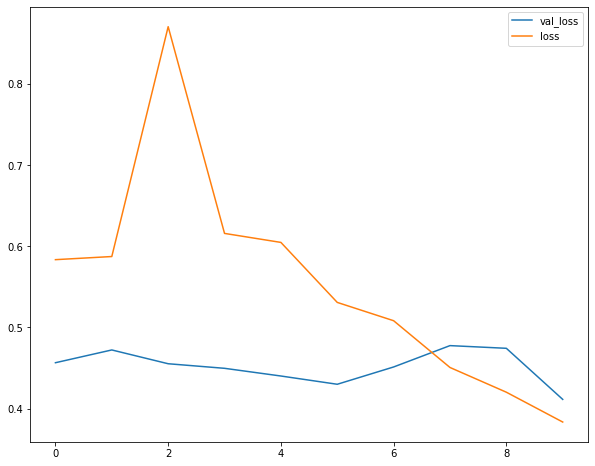

In [13]:
#plot:
plt.figure(figsize=(10,8))
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['loss'],label='loss')
plt.legend()

### Predict

In [14]:
# X_test:
X_input = data[-5:,:].reshape(1,5,data.shape[1])

In [15]:
# Predict: Load Model
saved_model = models.load_model('ts_un.h5')

In [16]:
y_pred_2008_2012 = saved_model.predict(X_input)

In [17]:
y_pred_2008_2012 = y_pred_2008_2012.reshape(5,y_pred_2008_2012.shape[2])

In [18]:
# Build back DF:
index_years = list(train.loc[:,'1980':'2007'].columns) + [str(x) for x in range(2008,2013)]
columns = list(train.loc[:,'1980':'2007'].index)
df_1972_2012 = pd.DataFrame(np.concatenate([data,y_pred_2008_2012]),index=index_years,columns=columns)


In [19]:
# Put into right format
df_1972_2012_unscaled = scaler.inverse_transform(df_1972_2012.values)

df_1972_2012_unscaled = pd.DataFrame(df_1972_2012_unscaled,index=index_years,columns=columns)

df_1972_2012_unscaled = df_1972_2012_unscaled.T



In [20]:
# Incase values became negative:
df_1972_2012_unscaled = df_1972_2012_unscaled[['2008','2012']].applymap(lambda x: abs(x))

In [21]:
# Submission columns:
df_pred = df_1972_2012_unscaled.loc[submission.index,:]

df_pred.columns = submission.columns

In [22]:
df_pred.to_csv('../bin/Final_Pred.csv')